In [1]:
# default_exp simulation

# Simulation

> Classes and helper fuction for generation 3D simulation data for SMLM

In [2]:
#hide
from nbdev.showdoc import *
from fastcore.test import *
from pdb import set_trace
from nbdev_template.utils import *
from nbdev_template.transforms import *
from nbdev_template.pointsource import *
import matplotlib.pyplot as plt

## 2D simulation
I am creating minimalistic example to better understand how 2d draw function - `draw_func` works in `DECODE` model. The funciton is located in https://github.com/mackelab/DECODE/blob/9d8b548d839dede798a2d2d3dbc8daa862f77c69/engine/LikelihoodModel.py#L287.

### Data preparation

In [3]:
from pathlib import Path
import inspect
import numpy as np
import torch

In [4]:
PATH = Path('/nrs/turaga/speisera/SMLM_2016/')

In [5]:
TRN_IMG_P  = PATH/'sequence-as-stack-MT0.N2.HD-AS-Exp.tif'
PSF_FILES  = Path('psf_chall_as.pkl')
SCALE      = 10
PRINT_FREQ = 500

LL_PARAMS  = {
             'p_act'   : 0.5, 
             'z_prior' : [0, 0.5],
             'surv_p'  : 0.5,
             'min_int' : 0.1,
             'p_lambda': 0.05
             }

PSF_PARAMS = {
             'modality': '3D',
             }

In [6]:
test_eq(type(tiff_imread(TRN_IMG_P)), np.ndarray)
test_eq(type(tiff_imread(str(TRN_IMG_P))), np.ndarray)
test_eq_type(tiff_imread(TRN_IMG_P), tiff_imread(str(TRN_IMG_P)))

In [7]:
#reading TRN_IMG
TRN_IMG = tiff_imread(TRN_IMG_P)
TRN_IMG.shape

(2500, 64, 64)

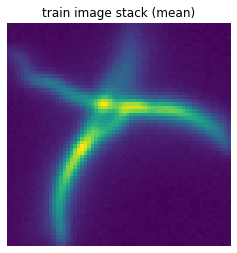

In [8]:
show_image(TRN_IMG.mean(0), title = 'train image stack (mean)');

### `draw_func`  2D
draw function is responsible for generating intial simulation ground truth data. This functions takes `M` which is normalized mean across our trainin data. We can get `M` using function `get_M` (small modification). Origiannaly `M` is `40 x 40`, since this is just for testing purpose our `M` will have dimensions of `64 x 64`. `M` gets normalized with `tanh` and `[p_act]` . 

from arthur:
>So basically the thought behind that weird  p_act * tanh( M / p_act ) is this: M is an estimate of the probability. of an emitter. So M / p_act is the probability that there is structure in that pixel. However if we update M during training this could become bigger then 1, which does not really make sense.  It can also be problematic when we do combined learning because we use lambda in the prior. So instead im using tanh( M / p_act) so it stays below 1, and then multiply again with p_act

We use normalized `M` to sample from `torch.distributions.Binomial` to generate most likely locations `locs1` of activated fluorophores. We also need x (`x_os`), y(`y_os`), and z(`z`) offsets. These offsets are sampled from `torch.distributions.Uniform` from `-0.5` to `0.5`.And lastly we need intensities `ints` which are also sampaled from  ` torch.distributions.Uniform` + `[min_int]`. Before returning the value we multiply `x_os`, `y_os`, `z` and `ints` with `locs`. 

Below I will just rewrite a little bit original `draw_func` so I can isolate the function and better understand whats hapening. Origianl `draw_func` is located here: https://github.com/mackelab/DECODE/blob/9d8b548d839dede798a2d2d3dbc8daa862f77c69/engine/LikelihoodModel.py#L287

In [9]:
def get_M(trainf, ll_pars):
    '''https://github.com/mackelab/DECODE/blob/9d8b548d839dede798a2d2d3dbc8daa862f77c69/engine/Model.py#L151'''
    map_ini = trainf.mean(0) - trainf.mean(0).min()
    map_ini /= map_ini.sum()
    map_ini *= ((ll_pars['p_act'] * ll_pars['p_lambda'] * trainf[0].size))
    train_map = map_ini.astype('float32')
    return train_map

In [10]:
test_eq(get_M(TRN_IMG, LL_PARAMS).shape, (64, 64))
test_eq(type(get_M(TRN_IMG, LL_PARAMS)), np.ndarray)

In [11]:
M = get_M(TRN_IMG, LL_PARAMS)

In [12]:
def draw_func(M, ll_pars, psf_pars, batch_size=1, local_context=False):
    λ = ll_pars['p_act'] * torch.tanh(M / ll_pars['p_act']).to('cuda')
    λ = λ.reshape(1,1,λ.shape[-2], λ.shape[-1]).repeat_interleave(batch_size, 0)
    locs1 = torch.distributions.Binomial(1, λ).sample().to('cuda')
    
    zeros = torch.zeros_like(locs1).to('cuda')

    z = torch.distributions.Normal(zeros+ll_pars['z_prior'][0], zeros+ll_pars['z_prior'][1]).sample().to('cuda')
    if '3D' in psf_pars['modality']:
        torch.tanh_(z)
        
    x_os = torch.distributions.Uniform(zeros-0.5, zeros+0.5).sample().to('cuda')
    y_os = torch.distributions.Uniform(zeros-0.5, zeros+0.5).sample().to('cuda')
    
    if 'backg_max' in ll_pars:
        bg = torch.distributions.Uniform(torch.zeros(batch_size).to('cuda')+0.01, torch.ones(batch_size).to('cuda')-0.01).sample().to('cuda')
    else:
        bg = None

    if local_context:
    
        α = ll_pars['surv_p']
        a11 = 1 - (1 - λ) * (1 - α)

        locs2 = torch.distributions.Binomial(1, (1 - locs1) * λ + locs1 * a11).sample().to('cuda')
        locs3 = torch.distributions.Binomial(1, (1 - locs2) * λ + locs2 * a11).sample().to('cuda')

        locs = torch.cat([locs1, locs2, locs3], 1)
        
        x_os = x_os.repeat_interleave(3,1)
        y_os = y_os.repeat_interleave(3,1)
        z = z.repeat_interleave(3,1)
 
    else:
        locs = locs1            
    ints = torch.distributions.Uniform(torch.zeros_like(locs)+ll_pars['min_int'], torch.ones_like(locs)).sample().to('cuda')

    x_os *= locs
    y_os *= locs
    z *= locs
    ints *= locs
    return locs,x_os,y_os,z,ints,bg

In [13]:
locs_2d, x_os_2d, y_os_2d, z_2d, ints_2d, _ = draw_func(torch.tensor(M), LL_PARAMS, PSF_PARAMS, local_context=True)

In [14]:
list(map(lambda x: getattr(x, 'size')(), [locs_2d, x_os_2d, y_os_2d, z_2d, ints_2d]))

[torch.Size([1, 3, 64, 64]),
 torch.Size([1, 3, 64, 64]),
 torch.Size([1, 3, 64, 64]),
 torch.Size([1, 3, 64, 64]),
 torch.Size([1, 3, 64, 64])]

In [15]:
sz = (64, 64)

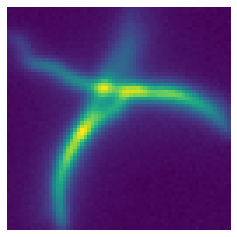

In [16]:
show_image(M)

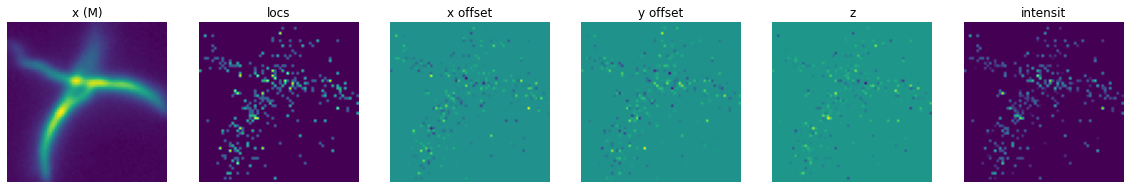

In [17]:
fig, axes = plt.subplots(1, 6, figsize=(20, 20))
show_image(torch.tensor(M)           .view(*sz), title= 'x (M)'   , ax = axes[0])
show_image(locs_2d           .mean(1).view(*sz), title= 'locs'    , ax = axes[1])
show_image(x_os_2d           .mean(1).view(*sz), title= 'x offset', ax = axes[2])
show_image(y_os_2d           .mean(1).view(*sz), title= 'y offset', ax = axes[3])
show_image(z_2d              .mean(1).view(*sz), title= 'z'       , ax = axes[4])
show_image(ints_2d           .mean(1).view(*sz), title= 'intensit', ax = axes[5]);

## 3D simulation

In [18]:
TRN_IMG_3D_P = Path('/nrs/turaga/smlm_data/SvobodaWang_mFISH/sample.ALM.tif')

In [19]:
TRN_IMG_3D = torch.tensor(tiff_imread(TRN_IMG_3D_P).astype('int32')); TRN_IMG_3D.shape

torch.Size([101, 3, 960, 960])

In [20]:
TRN_IMG_3D[:, 2, ::].max()

tensor(3169, dtype=torch.int32)

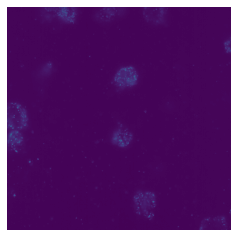

In [21]:
show_image(TRN_IMG_3D[:, 1, ::][0])

`TRN_IMG_3D` is `3d` dimensional data with `3` channels.


<ul>
<li>channel 0 - <code style="background:yellow;color:black">dye bacground?</code></li>
<li>channel 1 - actual RNA</li>
<li>channel 2 - <code style="background:yellow;color:black">bacground?</code></li></li>
</ul>

For now I can just work with `channel 1`, the code should be flexible to handle other channels if added late and just work on small random `200 x 200` piece  

In [22]:
TRN_IMG_3D_small = TRN_IMG_3D[:, 1, 0:100, 200:300]; TRN_IMG_3D_small.shape

torch.Size([101, 100, 100])

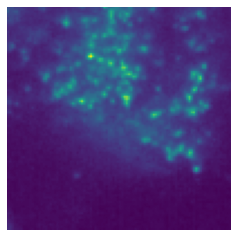

In [23]:
show_image(TRN_IMG_3D_small[0])

### `draw_func`  3D

from arthur:
> The most work will be going from 2D to 3D in the generative model. But the basic principle is rather simple. Right now I have x and y offsets, and the absolute z variable which is treated differently. Now you have 3 offset variables instead which should all be treated the same (except that the PSF width still scales with z). So mostly just copy/paste those lines and add another dimension

Things that need to be adress:

<div class="alert alert-block alert-warning">
<b>1:</b> Normalizing Data before giving to draw function.
</div>

in 2d we use function `get_M` which is responsible for noramalization. `get_M` also takes `dict` which contains `[p_act] = 0.5`  and `[p_lambda] = 0.05`. I guess we dont need them for `mFISH` data since all fluorophores are active?

from arthur

> Well for simulator learning we don't update it, because we don't use any real data The only thing to do is place emitters randomly with a density that is roughly the same as in the actual data we wan't to analyse. So that's why you can just use a constant and keep it like that

Srini suggested
> that instead of keeping `M` contant it will be better to use Arthur previos aproach where he uses training data as probability map for sampling from `torch.distributions.Binomial`. For this purpose `M` should be Scaled between `0.001` - `0.05`

In [24]:
M_3D = TRN_IMG_3D_small.type(torch.float32)

<div class="alert alert-block alert-danger">
<b>ScaleTensor:</b> Need to decide if we are using batch specifc data_min and data_max or global statistic from full 3D dataset
</div>

In [25]:
data_min = M_3D.min()
data_max = M_3D.max()
low      = torch.tensor(0.001)
high     = torch.tensor(0.05)

In [26]:
scaler = ScaleTensor(low=low, high=high, data_min = data_min, data_max = data_max)

In [27]:
scaler = ScaleTensor(low=low, high=high, data_min = data_min, data_max = data_max)
M_3D_scaled = scaler(M_3D)
M_3D_scaled.shape

torch.Size([101, 100, 100])

In [28]:
show_doc(PointSourceGaussian)

<h2 id="PointSourceGaussian" class="doc_header"><code>class</code> <code>PointSourceGaussian</code><a href="https://github.com/habib.s.t.bukhari/nbdev_template/tree/master/nbdev_template/pointsource.py#L10" class="source_link" style="float:right">[source]</a></h2>

> <code>PointSourceGaussian</code>(**`min_int`**:`float`) :: [`TransfromBase`](/nbdev_template/transforms#TransfromBase)

    Sample Point Source from Gaussina and Binomial Distribution

    
 This class is part of generative model and uses probility density map `m` to generate
    locations `loc`  `x`, `y`, `z` offsets and `ints` intensity of emitters. `m` should be
    `torch.tensor` scaled from 0.001 to 1, which is used by `_sample_bin` to generate `0` and
    `1` . `0` means that we dont have emitter at given pixel and 1 means emitters is presnet. This
    map is used to generate offset in `x`, `y`, `z` and intensities which tells how bright is emitter
    or in same casses how many emitters are bound to RNA molecules.


    
Parameters:
    
`min_int`     : minimum intensity of emitters

    
Returns:
    
`locs`: locations of the emitters
    
`x_os`: x offset of the emitters
    
`y_os`: y offset of the emitters
    
`z_os`: z offset of the emitters
    
`ints`: z intensity of the emitters


    

In [28]:
min_int = 0.1
sam = PointSourceGaussian(min_int)

In [33]:
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d = sam(M_3D_scaled)

In [34]:
list(map(lambda x: getattr(x, 'size')(), [locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d,]))

[torch.Size([101, 100, 100]),
 torch.Size([101, 100, 100]),
 torch.Size([101, 100, 100]),
 torch.Size([101, 100, 100]),
 torch.Size([101, 100, 100])]

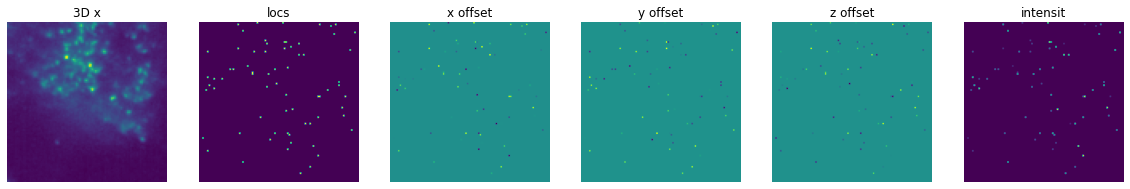

In [35]:
idx = 2
fig, axes = plt.subplots(1, 6, figsize=(20, 20))
show_image(TRN_IMG_3D_small  [idx], title= '3D x'    , ax = axes[0])
show_image(locs_3d           [idx], title= 'locs'    , ax = axes[1])
show_image(x_os_3d           [idx], title= 'x offset', ax = axes[2])
show_image(y_os_3d           [idx], title= 'y offset', ax = axes[3])
show_image(z_os_3d           [idx], title= 'z offset', ax = axes[4])
show_image(ints_3d           [idx], title= 'intensit', ax = axes[5])

In [36]:
def compose(x, list_func, order_key='_order'):
    for func in list_func: x = func(x)
    return x

In [37]:
scaler = ScaleTensor(low=low, high=high, data_min = data_min, data_max = data_max)
sampling = PointSourceGaussian(min_int)
compose_func = [scaler, sampling]
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d = compose(M_3D, compose_func)
list(map(lambda x: getattr(x, 'size')(), [locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d,]))

[torch.Size([101, 100, 100]),
 torch.Size([101, 100, 100]),
 torch.Size([101, 100, 100]),
 torch.Size([101, 100, 100]),
 torch.Size([101, 100, 100])]

## Applying PSF

After getting our `data` we need to apply PSF. Currently applying `PSF` function happens in `LikelihoodModel` and consist of following steps:

`data`
>`locs`, `x_offset`, `y_offset`, `z_offset`, `ints` <br/>

`LikelihoodModel` steps
>`datagen_func` --> `genfunc` --> `transform_offsets` <br/>
> ..................................................... --> `psf_func` -> `interpolate_tri` <br/>
>...................................................... --> `place_psfs`

In [36]:
#3d data
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d;
#2d data
locs_2d, x_os_2d, y_os_2d, z_2d, ints_2d;

### `datagen_func` 2D

```python
def datagen_func(self, S, X_os, Y_os, Z, I):
    batch_size,n_inp, w, h = S.shape[0], S.shape[1], S.shape[2], S.shape[3]
    xyzi = torch.cat([X_os.reshape([-1, 1, h, w]), Y_os.reshape([-1, 1, h, w]),Z.reshape([-1, 1, h, w]), I.reshape([-1, 1, h, w])], 1)
    recs = self.genfunc(S.reshape([-1, h, w]), xyzi)
    torch.clamp_min_(recs,0)
    x_sim = recs.reshape([batch_size, n_inp, h, w]) 

    return x_sim
```

In [37]:
S=locs_2d
batch_size,n_inp, w, h = S.shape[0], S.shape[1], S.shape[2], S.shape[3]
locs_2d.shape, batch_size,n_inp, w, h 
xyzi = torch.cat([x_os_2d.reshape([-1, 1, h, w]), y_os_2d.reshape([-1, 1, h, w]),z_2d.reshape([-1, 1, h, w]), ints_2d.reshape([-1, 1, h, w])], 1)

In [38]:
 S.reshape([-1, h, w]).shape, xyzi.shape,

(torch.Size([3, 64, 64]), torch.Size([3, 4, 64, 64]))

### `genfunc` 2D
```python
def genfunc(self, S, XYZI, add_wmap=True):
    X_os, Y_os, Z, I = self.transform_offsets(S, XYZI, self.beads_fit)
    W = self.psf_func(X_os, Y_os, Z, I, add_wmap)
    return 1000 * self.psf_pars['scale'] * self.place_psfs(W, S)
    
```

In [39]:
s_inds = S.nonzero().transpose(1,0)

### `transform_offsets` 2D
```python
def transform_offsets(self, S, XYZI, beads=False):
    
    if beads:
        
        n_imgs = S.shape[0]
        n_beads = XYZI[0].shape[-1]
        
        s_inds = S.nonzero()
        x_os_vals = XYZI[0].repeat_interleave(n_imgs,0)[:,0].reshape([-1])[:,None,None]
        y_os_vals = XYZI[0].repeat_interleave(n_imgs,0)[:,1].reshape([-1])[:,None,None]
        i_vals = XYZI[1].repeat_interleave(n_imgs,0).reshape([-1])[:,None,None]
        z_vals = XYZI[2].repeat_interleave(n_beads,0)[:,None,None]
        self.z_for_map_ind = z_vals[:,0,0] + self.psf_pars['z_scale']
        
    else:
    
        n_samples = S.shape[0] // XYZI.shape[0]
        XYZI_rep = XYZI.repeat_interleave(n_samples, 0)

        s_inds = tuple(S.nonzero().transpose(1,0))
        x_os_vals = (XYZI_rep[:,0][s_inds])[:,None, None]
        y_os_vals = (XYZI_rep[:,1][s_inds])[:,None, None]
        i_vals = (XYZI_rep[:,3][s_inds])[:,None,None]
        if '3D' in self.psf_pars['modality']:
            z_vals = self.psf_pars['z_scale'] * XYZI_rep[:,2][s_inds][:,None,None]
            self.z_for_map_ind = z_vals[:,0,0] + self.psf_pars['z_scale']
        else:
            z_vals = (1 + func.softplus(XYZI_rep[:,2][s_inds]))[:,None,None]
            self.z_for_map_ind = XYZI_rep[:,2][s_inds] + self.psf_pars['z_scale']
    
    return x_os_vals, y_os_vals, z_vals, i_vals
    
```

### `psf_func` 2D
```python
def psf_func(self, X_os, Y_os, Z, I, add_wmap=True):
    if add_wmap:
        self.filt_size = self.w_map.shape[-1]
    
    v = torch.arange(self.filt_size) - self.filt_size // 2
    v = v.reshape([1, self.filt_size]).float().cuda()
    
    if self.psf_pars['modality'] == 'GAUSS_2D':
             
        W_x = (v[None,:,:] - X_os) ** 2
        W_y = (v.transpose(1,0)[None,:,:] - Y_os) ** 2
        W = self.psf_pars['w_prop'] * torch.exp(-(W_x + W_y) / (2 * (Z * self.psf_pars['width1']) ** 2 + self.taylor_corr)) / (2 * np.pi * (Z * self.psf_pars['width1']) ** 2 + self.taylor_corr)
        W += (1 - self.psf_pars['w_prop']) * torch.exp(-(W_x + W_y) / (2 * (Z * self.psf_pars['width2']) ** 2 + self.taylor_corr)) / (2 * np.pi * (Z * self.psf_pars['width2']) ** 2 + self.taylor_corr)
            
    if self.psf_pars['modality'] == 'ASTIG_3D':
        
        om_x = 0.5 * self.psf_pars['om_0'] * torch.sqrt(1 + ((Z - self.psf_pars['c_x']) / self.psf_pars['d']) ** 2)
        om_y = 0.5 * self.psf_pars['om_0'] * torch.sqrt(1 + ((Z - self.psf_pars['c_y']) / self.psf_pars['d']) ** 2)
        W_x = (v[None,:,:] - X_os) ** 2
        W_y = (v.transpose(1,0)[None,:,:] - Y_os) ** 2
        W = torch.exp(-W_x / (2 * (om_x ** 2 + self.taylor_corr))) * torch.exp(-W_y / (2 * (om_y ** 2 + self.taylor_corr))) / (2 * np.pi * (om_x * om_y + self.taylor_corr))       
         
    if self.psf_pars['modality'] == 'HELIX_3D':
        
        x_shift = -self.psf_pars['rad']*torch.cos(self.psf_pars['rot_multi']*Z + self.psf_pars['zero_rot'])
        y_shift = self.psf_pars['rad']*torch.sin(self.psf_pars['rot_multi']*Z + self.psf_pars['zero_rot'])   
        
        W1 = torch.sqrt((v[None,:,:] - (X_os + x_shift)) ** 2 + (v.transpose(1,0)[None,:,:] - (Y_os + y_shift)) ** 2)
        W = torch.exp(-W1 ** 2 / (2 * (self.psf_pars['width']) ** 2 + self.taylor_corr)) / (2 * np.pi * (self.psf_pars['width']) ** 2 + self.taylor_corr)
        W2 = torch.sqrt((v[None,:,:] - (X_os - x_shift)) ** 2 + (v.transpose(1,0)[None,:,:] - (Y_os - y_shift)) ** 2)
        W += torch.exp(-W2 ** 2 / (2 * (self.psf_pars['width']) ** 2 + self.taylor_corr)) / (2 * np.pi * (self.psf_pars['width']) ** 2 + self.taylor_corr)
        
        W /= 2            
        
    if self.psf_pars['modality'] == 'ELIPSE_2D':
        
        om_x = Z * self.psf_pars['om_0'] * (1 + self.psf_pars['ellipticity'])
        om_y = Z * self.psf_pars['om_0']
        
        W_x = (v[None,:,:] - X_os) ** 2
        W_y = (v.transpose(1,0)[None,:,:] - Y_os) ** 2
        
        W = torch.exp(-W_x / (2 * (om_x ** 2 + self.taylor_corr))) * torch.exp(-W_y / (2 * (om_y ** 2 + self.taylor_corr))) / (2 * np.pi * (om_x * om_y + self.taylor_corr))
            
    if add_wmap: 
        maps = self.interpolate_tri(self.w_map, X_os, Y_os, self.z_for_map_ind,self.interpolate)
        W += maps
          
    W /= W.sum(-1).sum(-1)[:,None,None] 
    W *= I     
    
    return W
```


In [40]:
from nbdev.export import *
notebook2script()

Converted 00_models.ipynb.
Converted 01_simulation.ipynb.
Converted index.ipynb.
Converted pointsource.ipynb.
Converted transforms.ipynb.
Converted utils.ipynb.
